# Adjustment Recommendations (adjRec.py)

## Introduction

This notebook details the adjustment recommendation process. The output of this script is a pre-requisite for the OCR process ("ocr_use.py"). This script generates a set of recommended image adjustment parameter values that will produce the best OCR results for a given volume. These recommendations are then used to adjust the images before the OCR process. The adjRec.py script makes use of several functions from ocr_func.py.

The general structure of this script is as follows:
1. Pick a sample and establish baseline OCR performance
    * Randomly select n sample images from a given volume and crop them to the dimensions designated by marginalia_determination.py. 
    * Perform OCR on each sample image without any adjustments to establish baseline OCR 'readability.'
    * Create an instance of the `testList` class with the n sample images, with all adjustable parameters (color, sharpness, etc.) set to default.
2. Perform an adjustment test for each parameter. 
    * These tests adjust each sample image by a given range of parameter values (levels) and perform OCR on each new image version. 
    * Average readability is then determined across all images for each parameter level. 
    * From these results, the "best" parameter adjustment level is identified from the range of levels provided (including the default) based on the highest average readability score.
    * If the "best adjustment" level is different from the default, all images in the `testList` are adjusted accordingly before moving to the next parameter test.
3. Once the optimal levels are determined for each parameter, record all recommended adjustment levels.
    * The levels are stored in a dictionary (`adjustments`), which can then be written to .csv for use as input in later OCR scripts.
    * If one chooses to run this procedure for multiple volumes at once, the `adjustments` dictionary for each volume can be added to a list. The adjustments for all volumes can then be written to a .csv in bulk.
    

## Imports / Setup

In [1]:
import os, sys
import pandas as pandas
from random import sample
import csv

#get ocr functions
sys.path.append(os.path.abspath("./"))
from ocr_func import cutMarg, OCRtestImg, testList

#for adjustTest demo
from ocr_func import adjustImg

#for adjust comparison demo
from PIL import Image

#for demo image display
from IPython.display import Image, display

## Gathering Metadata

In practice, the majority of the operations in this script take place as part of the `adjRec` function in the adjRec.py script. The arguments for the `adjRec` function are:
* **vol** (str): The name for the volume to be tested. Should not include "_jp2" (so for 1879, it's "lawsresolutionso1879nort")
* **dirpath** (str): The directory path for the folder where ALL volumes are located
* **masterlist** (str): The direct file path for xmljpegmerge_official.csv. This file contains metadata gathered from the Internet Archive as well as other manually compiled metadata ("filename," "leafNum", "side," etc.)
* **margdata** (str): The direct file path for the csv with marginalia data (the output from marginalia_determination.py)
* **n** (int): The sample size to use for testing (this is set to 10 by default but can be adjusted)


Under normal circumstances the user provides the function with path locations for `masterlist`, `margdata`, and `dirpath`. The values for `vol` and `n` are set manually. All 5 variables are then used as arguments to call the function below. Instead of calling the adjRec as a function, for this demonstration we set the arguments according to our sample images and metadata.

In [2]:
# Initialize variables for demonstration
dirpath = "./images"     
masterlist = "sample_metadata.csv"
margdata = "marginalia_metadata_demo.csv"
vol = "lawsresolutionso1891nort"
n = 10

The first step is to merge the two metadata files using the filename as a key. This adds the marginalia removal information to that stored in xmljpegmerge_official.csv. 

In [3]:
mastercsv = pandas.read_csv(masterlist)
margcsv = pandas.read_csv(margdata)
mastercsv["filename"] = mastercsv["filename"] + ".jpg" 
csv = mastercsv.merge(margcsv, left_on="filename", right_on="file")

## Gathering a Sample / Establishing Baselines

Next we create a random sample of 10 images from the volume we provided. In practice most of our volumes had hundreds or thousands of pages. For this demonstration we have included 10 sample images instead of an entire volume. The sampling code has been retained here to emulate the original script.

In [4]:
pool = []
csvf = csv[csv["filename"].str.startswith(vol)].set_index("filename")

for row in csvf.itertuples():
    pool.append(os.path.normpath(os.path.join(dirpath, vol + "_jpg/" + row.file)))

pool = sample(pool, n)

The following code accomplishes two tasks:
1. *Crops each image according to the metadata generated by the marginalia_determination process.* This includes the coordinates for the boundary box containing only the main body text as well as the rotation angle and the average background color for the original image. Each image is cropped to the boundary box coordinates (`left`, `up`, etc.), rotated according to the rotation angle (`rotate`), and given a border area with an RGB color value of `bkgcol` and a width of `border`. The resulting images are stored in `imgs`.
2. *Performs preliminary OCR on each cropped image to establish baseline readability for unadjusted images*. This is accomplished by the `OCRtestImg` from ocr_func.py. This function opens each image and performs OCR using Tesseract. OCR'd text is then tokenized with NLTK and compared to the SpellChecker dictionary to establish whether or not the word is "known" or "unknown". Geographic names are recognized using the values stored in the "geonames.txt" file. A record is created for the image that includes its filename, number of tokens, number of unknown words, readability score and list of unknown words. These items are returned as a dictionary for each image. The dictionaries are stored in `results`.

In [5]:
#Get images for files in sample, cut margins and make a test list
imgs = []
results = []

for img in pool:

    #get image name
    name = os.path.split(img)[1]

    #get values for cutting margins
    rotate = csvf.loc[name]["angle"]
    left = csvf.loc[name]["bbox1"]
    up = csvf.loc[name]["bbox2"]
    right = csvf.loc[name]["bbox3"]
    lower = csvf.loc[name]["bbox4"]
    bkgcol = (csvf.loc[name]["backR"], csvf.loc[name]["backG"], csvf.loc[name]["backB"])

    #cut the margins
    img = cutMarg(img = img, rotate = rotate, left = left, up = up, right = right,
                 lower = lower, border = 200, bkgcol = bkgcol)


    #add the new image to the list
    imgs.append(img)

    #perform an OCR test on the new image and add the results to the list
    results.append(OCRtestImg(img))

Once we have compiled the `imgs` and `results` lists for our sample images, we use them to create an instance of the `testList` class from ocr_func.py. The purpose of this class is to allow for multiple iterations of image adjustments and to compare the OCR accuracy when those adjustments are applied. The `testList` class consists of the `images` and `results` properties created from the lists as well as two methods: `adjustTest` and `adjustImg`.

In [6]:
#create a testList object with the  images and results
testSample = testList(imgs, results)

## Parameter Tuning

### The `adjustTest` function

The first function in `testList`, called `adjustTest`, accounts for much of the work accomplished by Adjustment Recommendations `(adjRec.py)` as a whole. This function performs all of the parameter adjustment tests required to compile the final set of recommended adjustments. Because this function is so foundational to the recommendation process, it is worth describing its component processes in detail.

To begin, `adjustTest` receives two arguments:
1. **test**: The specifc image adjustment parameter to be tested. This can include any of the adjustments available through the `adjustImg` function in ocr_func.py. These include: *color, brightness, contrast, autocontrast, sharpness, invert, blur, sharpen, smooth, & xsmooth.*
2. **levels**: The range of levels to which the parameter in question will bet set to run a range of tests. This defaults to 0, .25, .5, .75, and 1.0 for 'continuous' tests, but can be adjusted to the test or image set being used. This argument is ignored when a 'boolean' test is provided.

For the purposes of this demonstration we will run the "color" test using the default levels. The initial variable declarations are as follows:

In [7]:
#arguments for demonstrations
test = "color"
levels = levels=[0,.25,.5,.75,1]

#Replace class attributes with local variables for demonstration purposes
testList_imgs = imgs
testList_results = results

#Initial variable declarations
resultsT = {}                       #results table
totaltok = []                       #total tokens for each file
rownum = 0                          #row number
names = {}                          #dictionary for renaming row indices
results = {}                        #dictionary with results to return
readults = "\nTOTAL READABILITY"    #readability results to return
topScore = 0                        #highest readability score
topAdj = "none"                     #adjustment with the best readability
state = True                        #initial state for boolean tests

First, it is important to distinguish between continuous tests and boolean tests. Continuous tests involve continuous parameters that require a range of float "level" values. Boolean tests involve parameters that can either be turned "on" or "off" and whose only potential values are "True" and "False". We make this distinction because the number of different "levels" will determine how many columns to create in order to compare the OCR results for different levels.

In [8]:
#Distinguish between continuous and boolean tests
conTests = ["color", "brightness", "contrast", "autocontrast", "sharpness"]
boolTests = ["invert", "blur", "sharpen", "smooth", "xsmooth"]

Next, we adjust the provided parameter for each image by each of the provided levels. We run OCR over each adjusted version and record the number of unknown words returned by each OCR pass.

For example, if the `test` argument matches one of the above `conTests`, we perform the following steps.
1. Iterate through all of the levels provided
2. For each level, create a header and a list (`resultsC` - "C" for "column"). The list will contain the number of unrecognized words returned by the OCR for each image when adjusted to that particular parameter level
3. For each level, iterate through all images contained in the `images` property of `testList`. Record the image's name and adjust it using the given parameter and level. This is accomplished using the `adjustImg` function in ocr_func.py.
4. Once the adjustment has been made to an individual image, perform OCR on the newly adjusted version using `OCRtestImg`. While this function returns several different results, the return value of interest here is `unknown_words`. This is the count of words that were not recognized by the SpellChecker dictionary. This value is added to `resultsC`.
    * Once you have iterated through each image for a given parameter level, you are left with a header that describes the test and level as well as the number of unknown words returned by the OCR process for each individual image in your sample. This creates a "column" of results for the level in question.
6. Repeat steps 2-4 for each level. For continuous tests, this will result in five columns, one for each level, if one uses the default "levels" argument. For boolean tests, there will only be two columns - one "True" and one "False". These columns will make up a results table for the whole test called `resultsT` ("T" for "table).

In [9]:
# Please note that in this demonstration all of the class attribute
# syntax has been converted for use with local variables.
# self.images -> testList_images
# self.results -> testList_results


#Tests with continuous levels
if test in conTests:

    #build column for each level
    for level in levels:

        #create column header and start with empty column
        header = test + str(level)
        resultsC = []

        #loop through each sample image
        for img in (testList_imgs): 

            #run image test, record unknown tokens
            name = img.info["name"]
            corImg = OCRtestImg(adjustImg(img, **{test: level}))
            resultsC.append(len(corImg["unknown_words"]))
            img.info = {"name" : name}

        #add column to table    
        resultsT[header] = resultsC

For our "color" test we ran OCR using each of 5 different levels: 0, 0.25, 0.5, 0.75, and 1.0. The number of unknown words returned by `OCRtestImg` has been recorded for each image and adjustment level. All 'level' columns have been added to `resultsT`, which is shown below:

In [10]:
# Demo resultsT before adding tokens/file names
resultsT_demo = pandas.DataFrame(resultsT)
resultsT_demo

,color0,color0.25,color0.5,color0.75,color1
0,1,1,1,1,1
1,5,5,5,5,5
2,5,4,4,2,2
3,3,3,3,3,3
4,0,0,0,1,1
5,4,4,4,4,5
6,1,1,1,1,2
7,6,7,6,7,6
8,3,3,3,3,3
9,1,1,1,1,1


If we had chosen to run one of the boolean tests (sharpen, blur, etc.), we would have performed the same operation as above with only two 'level' columns: one for "True" and one for "False". The "# change state" line at the bottom of this block changes the parameter from its initial state ("True") to "False."

In [11]:
#Tests with boolean states
if test in boolTests:

    #build columns for each state
    for i in range (0,2):

        #Create column header and start with empty column
        header = test + str(state)
        resultsC = []

        #loop through each sample image
        for img in (self.images): 

            #run image test, record unknown tokens
            name = img.info["name"]
            corImg = OCRtestImg(adjustImg(img, **{test: state}))
            resultsC.append(len(corImg["unknown_words"]))
            img.info = {"name" : name}                    

        #add column to table    
        resultsT[header] = resultsC

        #change state
        state = False    

If the user provides the function with an unknown test argument, it returns this message: "Invalid image adjustment test."

Next we create a dataframe from our table and set each row index equal to the name of the image file to which it pertains. We also add the total number of words ("tokens") returned by the original "baseline" OCR pass (`totaltok`). Recall that this number is stored as part of the `results` attribute of the `testList` class.

In [12]:
#DEMO - rownum/totaltok reset
rownum = 0
totaltok=[]

#get total tokens and filename
for img in testList_imgs:
    names[rownum] = img.info["name"]
    rownum += 1
for res in testList_results:
    totaltok.append(res["token_count"])

#create table and rename rows
resultsT["totaltok"] = totaltok
resultsT = pandas.DataFrame(resultsT)
resultsT = resultsT.rename(index = names)


Once we have adden token counts and the filenames to our table, `resultsT` appears as follows:

In [13]:
resultsT

,color0,color0.25,color0.5,color0.75,color1,totaltok
lawsresolutionso1891nort_1373.jpg,1,1,1,1,1,392
lawsresolutionso1891nort_1494.jpg,5,5,5,5,5,391
lawsresolutionso1891nort_0374.jpg,5,4,4,2,2,426
lawsresolutionso1891nort_0771.jpg,3,3,3,3,3,438
lawsresolutionso1891nort_0606.jpg,0,0,0,1,1,317
lawsresolutionso1891nort_0272.jpg,4,4,4,4,5,504
lawsresolutionso1891nort_1210.jpg,1,1,1,1,2,495
lawsresolutionso1891nort_0542.jpg,6,7,6,7,6,467
lawsresolutionso1891nort_1114.jpg,3,3,3,3,3,435
lawsresolutionso1891nort_0944.jpg,1,1,1,1,1,513


Using the information now stored in `resultsT`, we determine the the adjustment level that provided the best average OCR readability score for our sample. To do so, we get a sum of all tokens in all sample images (`totaltok`). We then iterate through each column and divide the total number of unknown words in each column by `totaltok` to arrive at a "readability" percentage score for that level. We determine which level resulted in the highest average "readability" (`topScore`) and store that level using `topAdj`. Each level and its associated readability score are stored in a string table called `readults`. 

The function returns a dictionary with the following keys/values:
1. **table**: The dataframe from which the readability scores are calculated, `resultsT`
2. **readability**: The string table which stores the calculated readability scores for each level
3. **topAdj**: The adjustment level that resulted in the top readability score

Both `table` and `readability` are printed to the console at the conclusion of each test for the benefit of the user.

In [14]:
#calculate readability for each level          
alltoks = resultsT["totaltok"].sum()
readults=""

for col in resultsT:
    total = 0
    if col != "totaltok":
        total = resultsT[col].sum()
        if total != 0:
            readability = round(100 - ((float(total)/float(alltoks)) * 100), 3)
        else:
            readability = 100
        readults = readults + "\n" + col + ": " + str(readability)
        if readability > topScore:
            topScore = readability
            topAdj = col

#return results
test_results = {
"table" : resultsT,
"readability" : readults,
"best_adjustment": topAdj
}

print ("\n\n")
print (test_results["table"])
print (test_results["readability"])




                                   color0  color0.25  color0.5  color0.75  \
lawsresolutionso1891nort_1373.jpg       1          1         1          1   
lawsresolutionso1891nort_1494.jpg       5          5         5          5   
lawsresolutionso1891nort_0374.jpg       5          4         4          2   
lawsresolutionso1891nort_0771.jpg       3          3         3          3   
lawsresolutionso1891nort_0606.jpg       0          0         0          1   
lawsresolutionso1891nort_0272.jpg       4          4         4          4   
lawsresolutionso1891nort_1210.jpg       1          1         1          1   
lawsresolutionso1891nort_0542.jpg       6          7         6          7   
lawsresolutionso1891nort_1114.jpg       3          3         3          3   
lawsresolutionso1891nort_0944.jpg       1          1         1          1   

                                   color1  totaltok  
lawsresolutionso1891nort_1373.jpg       1       392  
lawsresolutionso1891nort_1494.jpg       5

### Layered Parameter Adjustments

The previous section describes the processes involved with determining a recommended "level" for a single given parameter. The bulk of this operation takes place using scripts stored in ocr_func.py, particularly as part of the `testList` class. The remainder of the `adjRec` script uses the aformentioned mechanisms to sequentially peform a number of different parameter adjustment tests on our sample images. The recommended adjustment level from each individual test is stored as part of a dictionary tied to an individual volume. This dictionary constitutes the final output of the adjustment recommendation process: a dictionary storing the recommended levels for various parameters that taken together will result in the best average OCR readability for a given volume.

The first step is to set the default parameter levels. Each of these will be included in the `levels` argument passed to the `adjustTest` method along with other, non-default values.

In [15]:
#set up a dict of recommended adjustments and perform tests
adjustments = { "volume": vol, "color": 1.0, "invert": False, 
                "autocontrast": 0, "blur": False, "sharpen": False, 
                "smooth": False, "xsmooth": False }

After we have set our default parameter levels, we run the following tests:
1. **color**: tests adjustments made with the Pillow `ImageEnhance.Color()` function, used to adjust the colour balance of an image.
2. **autocontrast**: tests adjustments made with the Pillow `ImageOps.autocontrast()` function, used to maximize (normalize) image contrast
3. **blur**: tests adjustments made by passing Pillow's `ImageFilter.BLUR` filter as an argument to the Pillow `Image.filter()` function
4. **sharpen**: tests adjustments made by passing Pillow's `ImageFilter.SHARPEN` filter as an argument to the Pillow `Image.filter()` function
5. **smooth**: tests adjustments made by passing Pillow's `ImageFilter.SMOOTH` filter as an argument to the Pillow `Image.filter()` function
6. **xsmooth**: tests adjustments made by passing Pillow's `ImageFilter.SMOOTH_MORE` filter as an argument to the Pillow `Image.filter()` function


For more details regarding each specific image adjustment function, see [Pillow documentation](https://pillow.readthedocs.io/en/3.0.x/index.html).

*Note - the original set of tests included an "invert" test which adjusted the image using Pillow's `ImageOps.invert()` function. This test was removed because tesseract automatically inverts each image before commencing its OCR process.*


Below we'll break down the operation of the first test, "color." To begin, we print the current test to the console and pass the `test` and `levels` arguments to the `adjustTest` function. The return values from this function (see above) are stored in a dictionary called `testRes`.

In [16]:
#color test
print("color test")
testRes = testSample.adjustTest("color", levels = [1,.75,.5,.25,0])

color test



                                   color1  color0.75  color0.5  color0.25  \
lawsresolutionso1891nort_1373.jpg       1          1         1          1   
lawsresolutionso1891nort_1494.jpg       5          5         5          5   
lawsresolutionso1891nort_0374.jpg       2          2         4          4   
lawsresolutionso1891nort_0771.jpg       3          3         3          3   
lawsresolutionso1891nort_0606.jpg       1          1         0          0   
lawsresolutionso1891nort_0272.jpg       5          4         4          4   
lawsresolutionso1891nort_1210.jpg       2          1         1          1   
lawsresolutionso1891nort_0542.jpg       6          7         6          7   
lawsresolutionso1891nort_1114.jpg       3          3         3          3   
lawsresolutionso1891nort_0944.jpg       1          1         1          1   

                                   color0  totaltok  
lawsresolutionso1891nort_1373.jpg       1       392  
lawsresolutionso1891nort_1494.

(Having already run the "color" test, these results match those above.)

Next we extract the best adjustment float value from the `adjustTest` results. If that value is different from the default value (which, for the "color" test, is 1.0), all of the images in the sample are adjusted according to the "best" level of the parameter in question. 

This is accomplished using the `adjustSampleImgs` method of the `testList` class. The purpose of adjusting all of the sample images at the conclusion of a given test is to allow for adjustment "layering." This takes into account the possibility that results from one adjustment may affect the results of another adjustment. If we were to perform each adjustment test in isolation, we would be unable to gauge how well they work in concert. Because many volumes of images are likely to require multiple parameter adjustments to maximize OCR readability, layering adjustments gives a more realistic picture of a given volume's requirements. 

*Note - It may be true that the order in which we perform our tests affects the final adjustment recommendations. The current order was chosen by team members according to previous graphic design experience and tailored to the requirements of our image corpus. It may be useful to adjust the order of adjustment tests for use with different corpora.*

In [17]:
best = float(testRes["best_adjustment"].replace("color", ""))
if best != 1.0:
    testSample = testSample.adjustSampleImgs(color = best)
    adjustments["color"] = best

Our color test determined that a color adjustment level of .75 resulted in the best readability, so we adjust all images in our `testList` accordingly. In fact, there was a tie for our "best" adjustment level in this particular instance of the test. In the case of a tie, the first level with the highest readability score is selected as the "best" adjustment level. The "color" value of our final `adjustments` dictionary is changed from its default to the new "best" value of .75.

Next we run each of our tests in sequence. Once the "best" adjustment values for each have been determined, we adjust all of the `testList` images, add the "best" value to the adjustments dictionary, and move on to the next test.

In [18]:
#autocontrast test
print("autocontrast test")
testRes = testSample.adjustTest("autocontrast", levels = [0,2,4,6,8])
best = float(testRes["best_adjustment"].replace("autocontrast", ""))
if best != 0.0:
    testSample = testSample.adjustSampleImgs(autocontrast = best)
    adjustments["autocontrast"] = best

autocontrast test



                                   autocontrast0  autocontrast2  \
lawsresolutionso1891nort_1373.jpg              1              1   
lawsresolutionso1891nort_1494.jpg              5              6   
lawsresolutionso1891nort_0374.jpg              2              3   
lawsresolutionso1891nort_0771.jpg              3              3   
lawsresolutionso1891nort_0606.jpg              1              1   
lawsresolutionso1891nort_0272.jpg              4              3   
lawsresolutionso1891nort_1210.jpg              1              1   
lawsresolutionso1891nort_0542.jpg              7              5   
lawsresolutionso1891nort_1114.jpg              3              3   
lawsresolutionso1891nort_0944.jpg              1              1   

                                   autocontrast4  autocontrast6  \
lawsresolutionso1891nort_1373.jpg              1              1   
lawsresolutionso1891nort_1494.jpg              5              4   
lawsresolutionso1891nort_0374.jpg       

In [19]:
#blur test
print("blur test")
testRes = testSample.adjustTest("blur")
if testRes["best_adjustment"] == "blurTrue":
    testSample = testSample.adjustSampleImgs(blur = True)
    adjustments["blur"] = True

blur test



                                   blurTrue  blurFalse  totaltok
lawsresolutionso1891nort_1373.jpg         1          1       392
lawsresolutionso1891nort_1494.jpg         4          5       391
lawsresolutionso1891nort_0374.jpg         2          3       424
lawsresolutionso1891nort_0771.jpg         3          3       438
lawsresolutionso1891nort_0606.jpg         0          0       315
lawsresolutionso1891nort_0272.jpg         5          3       502
lawsresolutionso1891nort_1210.jpg         2          1       495
lawsresolutionso1891nort_0542.jpg         6          5       467
lawsresolutionso1891nort_1114.jpg         3          3       435
lawsresolutionso1891nort_0944.jpg         1          1       513

TOTAL READABILITY
blurTrue: 99.382
blurFalse: 99.428


In [20]:
#sharpen test
print("sharpen test")
testRes = testSample.adjustTest("sharpen")
if testRes["best_adjustment"] == "sharpenTrue":
    testSample = testSample.adjustSampleImgs(sharpen = True)
    adjustments["sharpen"] = True

sharpen test



                                   sharpenTrue  sharpenFalse  totaltok
lawsresolutionso1891nort_1373.jpg            1             1       392
lawsresolutionso1891nort_1494.jpg            5             5       391
lawsresolutionso1891nort_0374.jpg            1             3       424
lawsresolutionso1891nort_0771.jpg            3             3       438
lawsresolutionso1891nort_0606.jpg            0             0       315
lawsresolutionso1891nort_0272.jpg            3             3       502
lawsresolutionso1891nort_1210.jpg            1             1       495
lawsresolutionso1891nort_0542.jpg            7             5       467
lawsresolutionso1891nort_1114.jpg            4             3       435
lawsresolutionso1891nort_0944.jpg            1             1       513

TOTAL READABILITY
sharpenTrue: 99.405
sharpenFalse: 99.428


The "smooth" & "xsmooth" tests represent a special case in that the "xsmooth" test is only run if the "smooth" test identified the smoothed images as having better average readability than unsmoothed images. If it has been determined that smoothing increases overall readability, then we determine whether or not even more smoothing will further increase image quality. In this particular demonstration, the unsmoothed image was determined to have better readability than the smoothed image, so the "xsmooth" test was skipped.

In [21]:
#smooth test
print("smooth test")
testRes = testSample.adjustTest("smooth")
if testRes["best_adjustment"] == "smoothTrue":
    testSample = testSample.adjustSampleImgs(smooth = True)
    adjustments["smooth"] = True

    #xsmooth test
    print("xsmooth test")
    testRes = testSample.adjustTest("xsmooth")
    if testRes["best_adjustment"] == "xsmoothTrue":
        testSample = testSample.adjustSampleImgs(xsmooth = True)
        adjustments["xsmooth"] = True

        

smooth test



                                   smoothTrue  smoothFalse  totaltok
lawsresolutionso1891nort_1373.jpg           1            1       392
lawsresolutionso1891nort_1494.jpg           5            5       391
lawsresolutionso1891nort_0374.jpg           3            3       424
lawsresolutionso1891nort_0771.jpg           3            3       438
lawsresolutionso1891nort_0606.jpg           1            0       315
lawsresolutionso1891nort_0272.jpg           4            3       502
lawsresolutionso1891nort_1210.jpg           1            1       495
lawsresolutionso1891nort_0542.jpg           7            5       467
lawsresolutionso1891nort_1114.jpg           3            3       435
lawsresolutionso1891nort_0944.jpg           2            1       513

TOTAL READABILITY
smoothTrue: 99.314
smoothFalse: 99.428


Once we have completed all of the included tests, our `adjustments` dictionary will reflect all of the "best" parameter values for the volume in question. For our demonstration image set, the tests have determined that adjustments for "color" and "autocontrast" will result in improved OCR performance. Recall our adjustment default levels:
```
{ "volume": vol, 
    "color": 1.0, 
    "invert": False, 
    "autocontrast": 0, 
    "blur": False, 
    "sharpen": False, 
    "smooth": False, 
    "xsmooth": False }
```

In [22]:
#post-test adjustment levels
adjustments

{'volume': 'lawsresolutionso1891nort',
 'color': 0.75,
 'invert': False,
 'autocontrast': 4.0,
 'blur': False,
 'sharpen': False,
 'smooth': False,
 'xsmooth': False}

Examples for a typical page image adjustment can be seen below. In the first image, an unadjusted image is shown. The page has been cropped to the specifications laid out in the marginalia removal process and a border has been applied according to the "average" background color of the image.

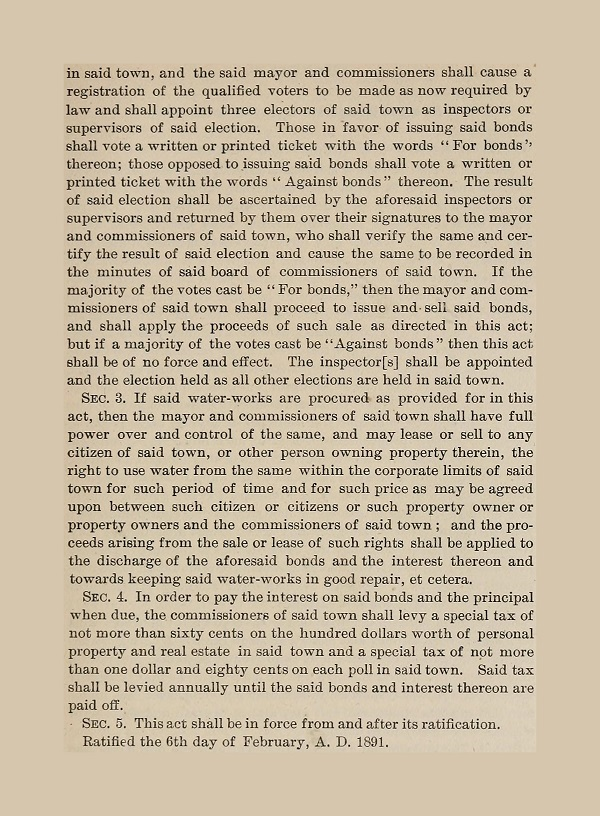

In [23]:
display(Image(filename='unadjusted.png', embed=True))

In the second image, an adjusted image is shown. This image is the same as the first image with the following adjustments:
* Color changed from 1.0 to .75
* Autocontrast changed from 0 to 4.0

This image, rather than that displayed above, is the version that would undergo the final OCR process in later steps.

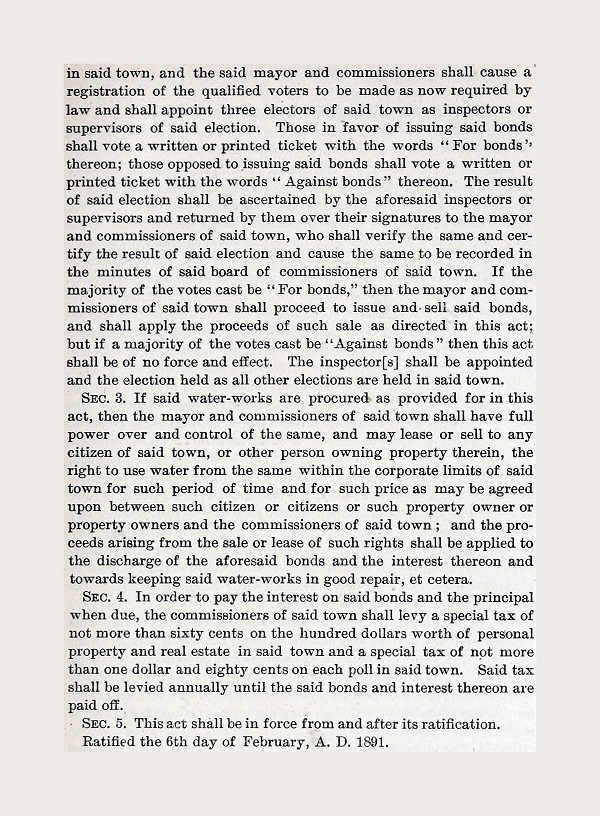

In [24]:
display(Image(filename='adjusted.png', embed=True))

## Exporting recommended adjustments

The above processes demonstrate the adjustment recommendation process for a single volume. If one only desires to complete the OCR process for a single volume, the dictionary output (`adjustments`) shown above can be used. However, in most cases, it is likely that we will generate adjustment recommendations for multiple volumes (or even the entire corpus) at once. We can serialize the above processes to achieve this goal using the code below.

In [ ]:
# ###########  Create a CSV with Adjustment Specs for all Volumes  ############## 

# Set the destination filepath
savefile = "adjustments_fixed.csv"

# Recall that 'dirpath' holds all volume-specific folders containing the page image files
for folder in os.listdir(dirpath):
    
    if folder == ".DS_Store":
        continue
    
    #get volume
    vol = folder.replace("_jp2", "")
    print ("Testing " + vol + "...")
    
    #peform adjustment tests 
    adjRow = adjRec(vol, dirpath, masterlist, margdata, 10)
    
    #record adjustments
    print("writing output")
    with open(savefile, "a") as f:
        w = csv.DictWriter(f, adjRow.keys())
        if f.tell() == 0:
            w.writeheader()
            w.writerow(adjRow)
        else: 
            w.writerow(adjRow)